NB: Next steps: add a pre-trained model to work off of, balance classes for training

In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics.functional import auroc, accuracy

from pytorch_lightning.trainer import seed_everything

In [64]:
seed_everything(seed=123)

Global seed set to 123


123

## Load train tabular dataset

In [65]:
col_types = {"image_name": str,
            "patient_id": str,
            "sex": str,
            "age_approx": np.float16,
            "anatom_site_general_challenge": str,
            "diagnosis": str,
            "benign_malignant": str,
            "target": np.uint8}
df = pd.read_csv("/mnt/derm/train.csv", dtype=col_types)
df.reset_index(drop=True, inplace=True)
df.head(20)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


## Splitting dataset into train / validation and test partitions

#### Pytorch dataset class (images saved in pytorch .pt files)

In [66]:
class MelanomaImageDataset(Dataset):
    def __init__(self, path, df):
        self.df = df
        if "target" in self.df.columns:
            self.target = torch.from_numpy(df.target.values).type(torch.FloatTensor)
        self.path = path

    def __getitem__(self, idx):
        image_name = self.df.image_name[idx]
        image = torch.load(os.path.join(self.path, image_name + '.pt'))
        if "target" in self.df.columns:
            label = self.target[idx]
            return image, label
        else:
            return image
                        
    def __len__(self):
        return self.df.shape[0]

In order to speed up training, JPEG images have been previously saved to tensor pytorch files. The dataset is available here: 
* [dataset images 64x64 grayscale](http://www.kaggle.com/dataset/47c2ca3a3c6c78afa4bce815570256cba79c6879366d5b9b33393097e4293312) 

The transformation applied to JPEG images is simply the following one:
```
custom_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(),
                                     ])
```

In [67]:
PATH_PT_FILE = '/mnt/derm/pre-processed/train/'
BATCH_SIZE = 128

# split train/val/test
train_df, val_df = train_test_split(df, stratify=df.target, test_size=0.20)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

val_df, test_df = train_test_split(val_df, stratify=val_df.target, test_size=0.5)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#creating train, valid and test datasets
train_ds = MelanomaImageDataset(PATH_PT_FILE, train_df)
valid_ds = MelanomaImageDataset(PATH_PT_FILE, val_df)
test_ds = MelanomaImageDataset(PATH_PT_FILE, test_df)
#creating train, valid and test dataloaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=6, shuffle=True) # previously: 32 workers
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=6, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=6, shuffle=False)

In [68]:
print(train_df.shape, val_df.shape, test_df.shape)
pd.DataFrame({'train': train_df.target.value_counts(), 'val': val_df.target.value_counts(), 'test': test_df.target.value_counts()})

(26500, 8) (3313, 8) (3313, 8)


,train,val,test
0,26033,3254,3255
1,467,59,58


## Pytorch Lightning model

In [69]:
class MelanomaModel(LightningModule):

    def __init__(self):
        super().__init__()
        # conv kernels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        # dense layers: an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid() 
        
        # callback metrics
        self.metrics = {'train_loss': [], 'train_acc': [], 'train_aucroc': [],
                        'val_loss': [], 'val_acc': [], 'val_aucroc': []}

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square we can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, start_dim=1) # except the batch size dim
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x).flatten()
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return {'loss': loss, "y_hat": y_hat, "y": y}
    
    def training_epoch_end(self, outputs):
        # concat or stack batchs outputs
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        train_y_hat = torch.cat([x['y_hat'] for x in outputs], dim=-1)
        train_y = torch.cat([x['y'].type(torch.int) for x in outputs], dim=-1)
        # compute accuracy and roc auc
        train_bin_y_hat = (train_y_hat > 0.5).float() * 1
        acc = accuracy(train_bin_y_hat, train_y)
        aucroc = auroc(train_y_hat, train_y)
        # print("train_loss {0:.6f} || train_acc {1:.6f} || train_aucroc {2:.6f}".format(avg_loss, acc, aucroc))
        # Record metrics
        self.metrics['train_loss'].append(avg_loss)
        self.metrics['train_acc'].append(acc)
        self.metrics['train_aucroc'].append(aucroc)
        #return {'train_loss': avg_loss}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.binary_cross_entropy(y_hat, y), "y_hat": y_hat, "y": y}

    def validation_epoch_end(self, outputs):
        # concat or stack batchs outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_y_hat = torch.cat([x['y_hat'] for x in outputs], dim=-1)
        val_y = torch.cat([x['y'].type(torch.int) for x in outputs], dim=-1)
        print(val_y[0].dtype)
        # compute accuracy and roc auc, ny
        val_bin_y_hat = (val_y_hat > 0.5).float() * 1
        acc = accuracy(val_bin_y_hat, val_y)
        aucroc = auroc(val_y_hat, val_y)
        # print("val_loss {0:.6f} || val_acc {1:.6f} || val_aucroc {2:.6f}".format(avg_loss, acc, aucroc))
        # Record metrics
        self.metrics['val_loss'].append(avg_loss)
        self.metrics['val_acc'].append(acc)
        self.metrics['val_aucroc'].append(aucroc)
        return {'val_loss': avg_loss, 'val_auc': aucroc} 

In [70]:
model = MelanomaModel()
model

MelanomaModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Test on a small batch

In [71]:
tensor_images = torch.randn(5, 1, 64, 64)
outputs = model(tensor_images)
print(outputs)

tensor([0.5131, 0.5138, 0.5135, 0.5132, 0.5137], grad_fn=<ViewBackward>)


## Training phase 

In [72]:
#%%time
early_stop_callback = EarlyStopping(monitor='val_aucroc',
                                    min_delta=0.00,
                                    patience=5,
                                    verbose=True,
                                    mode='max')
trainer = Trainer(max_epochs=100,
                  gpus=1,
                  check_val_every_n_epoch=1,
                  num_sanity_val_steps=0)#,
                 # callbacks=early_stop_callback)

trainer.fit(model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | conv1   | Conv2d  | 60    
1 | conv2   | Conv2d  | 880   
2 | conv3   | Conv2d  | 4.6 K 
3 | fc1     | Linear  | 138 K 
4 | fc2     | Linear  | 10.2 K
5 | fc3     | Linear  | 85    
6 | sigmoid | Sigmoid | 0     
------------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.617     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 234/234 [00:04<00:00, 51.39it/s, loss=0.0859, v_num=19]


In [73]:
#type(train_ds.target[0])
# train_ds.target[[0]]
#train_ds.target.type
torch.cuda.is_available()

True

#### Convert callback metrics: from tensor to numpy 

In [74]:
for key in model.metrics:
    model.metrics[key] = np.array([val.detach().cpu().numpy() for val in model.metrics[key]])

df_metrics = pd.DataFrame.from_dict(model.metrics)
df_metrics["epochs"] = np.arange(0, len(df_metrics))
df_metrics.head(3)

,train_loss,train_acc,train_aucroc,val_loss,val_acc,val_aucroc,epochs
0,0.108647,0.977925,0.617629,0.087352,0.982191,0.736595,0
1,0.091937,0.982377,0.627934,0.086482,0.982191,0.738127,1
2,0.090376,0.982377,0.605842,0.084947,0.982191,0.737101,2


#### Plots

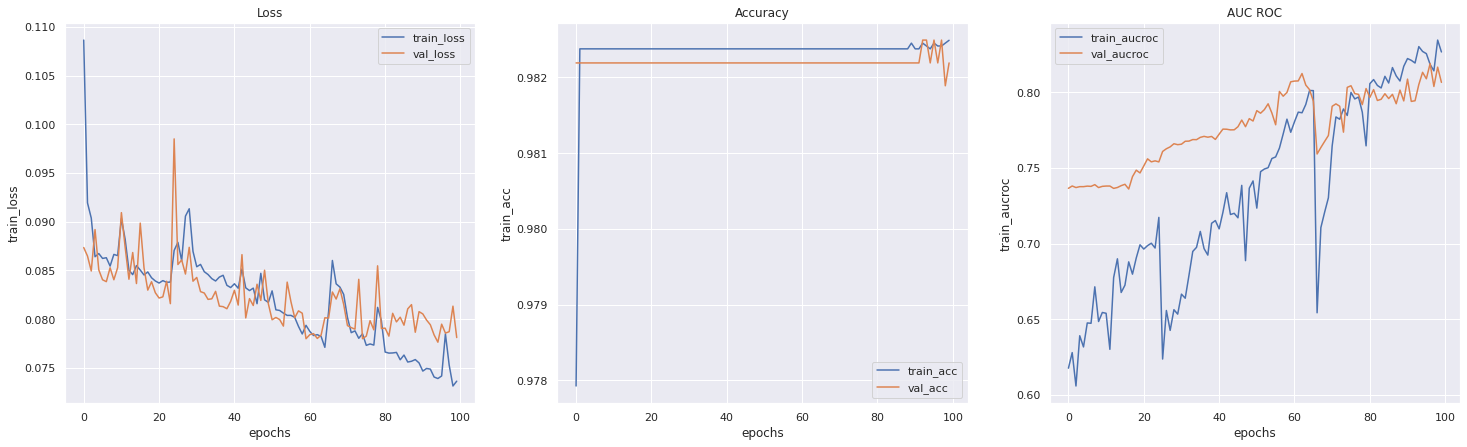

In [75]:
sns.set(font_scale=1.)
plt.figure(figsize=(25,7))
plt.subplot(131)
plt.title("Loss")
sns.lineplot(x="epochs", y="train_loss", data=df_metrics, label="train_loss")
sns.lineplot(x="epochs", y="val_loss", data=df_metrics, label="val_loss")
plt.subplot(132)
plt.title("Accuracy")
sns.lineplot(x="epochs", y="train_acc", data=df_metrics, label="train_acc")
sns.lineplot(x="epochs", y="val_acc", data=df_metrics, label="val_acc")
plt.subplot(133)
plt.title("AUC ROC")
sns.lineplot(x="epochs", y="train_aucroc", data=df_metrics, label="train_aucroc")
sns.lineplot(x="epochs", y="val_aucroc", data=df_metrics, label="val_aucroc")
plt.show()

## Performances on test dataset

#### Collect predictions

In [76]:
preds = []
for image, label in test_dl:
    preds.append(model(image).detach())

In [77]:
y_pred_prob = torch.cat(preds, dim=-1).cpu().numpy()
y_pred = np.where(y_pred_prob >= .5, 1, 0)
y_true = test_df.target.values

[Summary Statistics]
Accuracy = 98.28% | Precision = 100.00% | Recall = 1.72% | Specificity = 100.00% | F1 Score = 3.39%


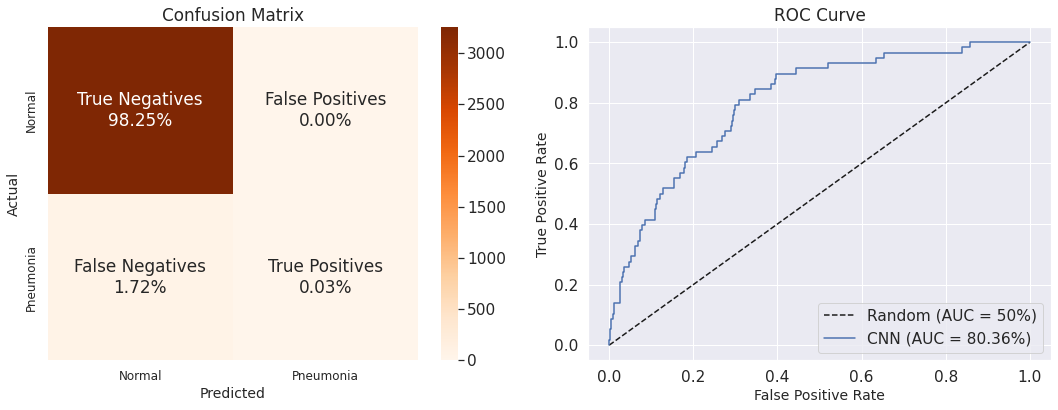

In [78]:
plt.figure(figsize=(15,6))

## CONFUSION MATRIX
plt.subplot(121)
# Set up the labels for in the confusion matrix
cm = confusion_matrix(y_true, y_pred)
names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Normal', 'Pneumonia']

# Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14) 
#plt.savefig('cm.png', transparent=True) 

## ROC CURVE
plt.subplot(122)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='best')
#plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)

## END PLOTS
plt.tight_layout()

## Summary Statistics
TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
acc = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
precision = TP / (TP+FP) # % positive out of all predicted positives
recall =  TP / (TP+FN) # % positive out of all supposed to be positives
specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
f1 = 2*precision*recall / (precision + recall)
stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(acc, precision, recall, specificity, f1)
print(stats_summary)